In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import emcee
import corner
from IPython.display import display, Math
import re
import os

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# The data

We start by reading some data.

In [3]:
trials = pd.read_csv('trials.csv', index_col=0)
measurements = pd.read_csv('measurements.csv', index_col=0)
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,weight_dry_1,weight_dry_2,weight_dry_3,weight_dry_4,weight_dry_5,weight_dry_6,weight_dry_7,notes
id,,,,,,,,,,,,,
38,4,7,0.438,2.8,3.493,0.513,0.509,0.510,0.512,0.511,0.510,0.510,NaN
39,4,8,0.435,2.0,3.584,0.493,0.490,0.490,0.492,0.492,0.492,0.491,NaN
40,4,9,0.433,1.5,3.488,0.473,0.470,0.471,0.474,0.474,0.472,0.473,NaN
41,4,10,0.435,1.1,3.551,0.464,0.462,0.460,0.466,0.463,0.462,0.465,NaN
42,4,11,0.436,0.8,3.448,0.459,0.456,0.455,0.458,0.457,0.457,0.458,NaN


The weight measurements during drying are organized as columns in the measurements table. However, it will make more sense here to rearrange these columns as separate samples.

In [4]:
value_vars = [col for col in measurements if col.startswith('weight_dry')]
id_vars = [ele for ele in measurements.columns if ele not in value_vars]
measurements = measurements.melt(id_vars=id_vars, value_vars=value_vars, 
                                 var_name='weight_id', value_name='dry_weight')
measurements['weight_id'] = measurements['weight_id'].apply(lambda x: int(re.search(r'\d+', x)[0]))
measurements = measurements.dropna(subset=['dry_weight'])
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,notes,weight_id,dry_weight
289,4,7,0.438,2.8,3.493,NaN,7,0.510
290,4,8,0.435,2.0,3.584,NaN,7,0.491
291,4,9,0.433,1.5,3.488,NaN,7,0.473
292,4,10,0.435,1.1,3.551,NaN,7,0.465
293,4,11,0.436,0.8,3.448,NaN,7,0.458


Weight measurement \#3 and \#4 represent the same sample--these are samples taken in the evening after the oven was turned off, and in the morning before it was turned on. We see this reflected in the weights of the samples, which don't change significantly. To clarify the analysis that follows, let's remove measurement \#4 from the data set.

In [5]:
measurements = measurements[measurements['weight_id'] != 4]
measurements['weight_id'] = measurements['weight_id'].apply(lambda x: x - 1 if x > 4 else x)
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,notes,weight_id,dry_weight
289,4,7,0.438,2.8,3.493,NaN,6,0.510
290,4,8,0.435,2.0,3.584,NaN,6,0.491
291,4,9,0.433,1.5,3.488,NaN,6,0.473
292,4,10,0.435,1.1,3.551,NaN,6,0.465
293,4,11,0.436,0.8,3.448,NaN,6,0.458


Now let's calculate TDS for each of the dry weights.

In [6]:
measurements['weight_dissolved'] = measurements['weight_boat_plus_liquid'] - measurements['weight_empty_boat']
measurements['weight_solid'] = measurements['dry_weight'] - measurements['weight_empty_boat']
measurements['tds'] = measurements['weight_solid'] / measurements['weight_dissolved']
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,notes,weight_id,dry_weight,weight_dissolved,weight_solid,tds
289,4,7,0.438,2.8,3.493,NaN,6,0.510,3.055,0.072,0.023568
290,4,8,0.435,2.0,3.584,NaN,6,0.491,3.149,0.056,0.017783
291,4,9,0.433,1.5,3.488,NaN,6,0.473,3.055,0.040,0.013093
292,4,10,0.435,1.1,3.551,NaN,6,0.465,3.116,0.030,0.009628
293,4,11,0.436,0.8,3.448,NaN,6,0.458,3.012,0.022,0.007304


Let's see what this looks like.

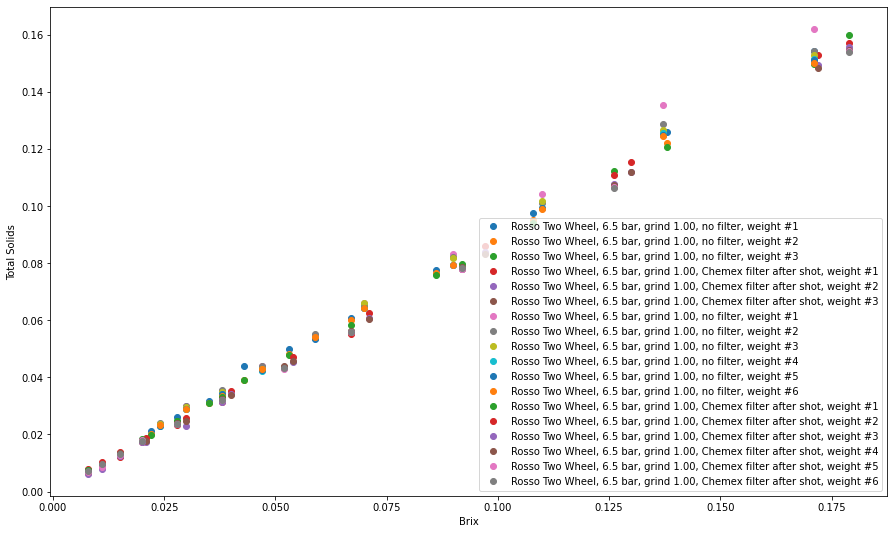

In [7]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brix')
ax.set_ylabel('Total Solids')

for (trial_id, weight_id), df in measurements.groupby(['trial_id', 'weight_id']):
    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])
    
    # Get trial description
    label = trials['description'][trial_id] + f', weight #{weight_id}'

    # Plot the data
    p = ax.plot(xs, ys, label=label, marker='o', linestyle='None')

# Add a legend to the plot
ax.legend()

If we focus on just the driest samples in the second experiment:

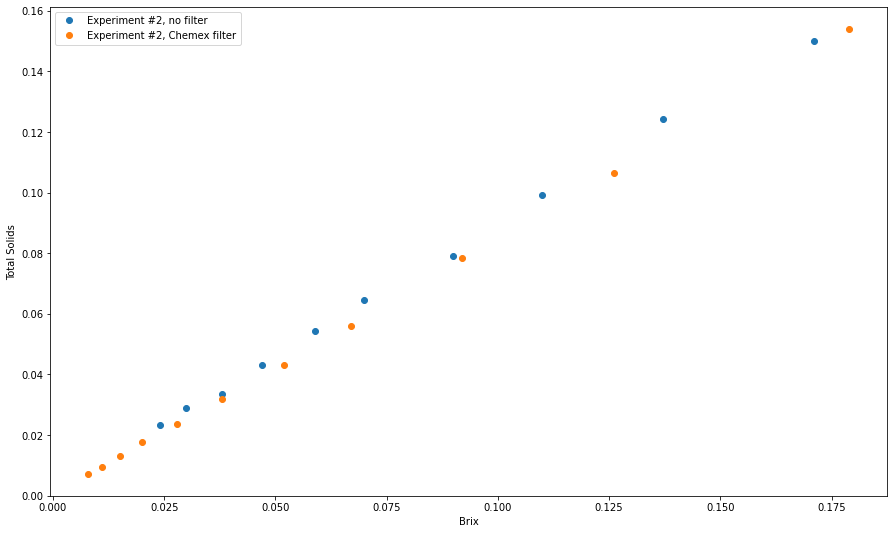

In [8]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brix')
ax.set_ylabel('Total Solids')

# Plot labels
labels = ['Experiment #2, no filter', 'Experiment #2, Chemex filter']

for i, trial_id in enumerate([3, 4]):
    one_trial = measurements[measurements['trial_id'] == trial_id]
    weight_id = one_trial['weight_id'].max()
    df = one_trial[one_trial['weight_id'] == weight_id]

    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])

    # Get trial description
    label = labels[i]

    # Plot the data
    p = ax.plot(xs, ys, label=label, marker='o', linestyle='None', color=f'C{i}')

# Add a legend to the plot
ax.legend()

Now let's fit a line to each trial and each drying time.

In [9]:
res = []

for (trial_id, weight_id), df in measurements.groupby(['trial_id', 'weight_id']):
    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])
    
    # Get linear regression
    m, _, _, _ = np.linalg.lstsq(xs[:,np.newaxis], ys, rcond=None)
    
    # Save regression
    res.append((trial_id, weight_id, m[0]))

slopes = pd.DataFrame(res, columns=['trial_id', 'weight_id', 'slope'])
slopes

,trial_id,weight_id,slope
0,1,1,0.910167
1,1,2,0.885939
2,1,3,0.877679
3,2,1,0.886642
4,2,2,0.861454
5,2,3,0.858908
6,3,1,0.953220
7,3,2,0.920638
8,3,3,0.912951
9,3,4,0.900213


Again we can plot this:

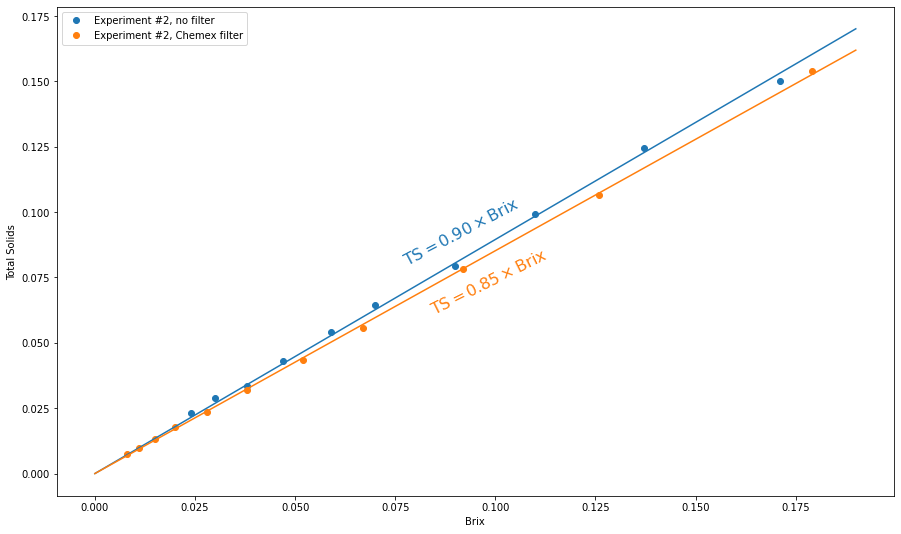

In [10]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brix')
ax.set_ylabel('Total Solids')

# Plot labels
labels = ['Experiment #2, no filter', 'Experiment #2, Chemex filter']

for i, trial_id in enumerate([3, 4]):
    one_trial = measurements[measurements['trial_id'] == trial_id]
    weight_id = one_trial['weight_id'].max()
    df = one_trial[one_trial['weight_id'] == weight_id]

    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])

    # Get trial description
    label = labels[i]

    # Plot the data
    p = ax.plot(xs, ys, label=label, marker='o', linestyle='None', color=f'C{i}')

# Add a legend to the plot
ax.legend()

for i, trial_id in enumerate([3, 4]):
    one_trial = measurements[measurements['trial_id'] == trial_id]
    weight_id = one_trial['weight_id'].max()

    # Plot best fit
    xs = np.linspace(0., 0.19, 2)
    m = slopes['slope'][(slopes['weight_id'] == weight_id) & (slopes['trial_id'] == trial_id)].values[0]
    ys = m * xs
    color = f'C{i}'
    ax.plot(xs, ys, color=color)
    
    # Get slope in plot
    p1 = ax.transData.transform_point((xs[0], ys[0]))
    p2 = ax.transData.transform_point((xs[1], ys[1]))
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    rotn = np.degrees(np.arctan2(dy, dx))
    
    # Get label position
    xylabel = ((xs[0]+xs[1])/2, (ys[0]+ys[1])/2)
    if trial_id == 3: xytext = (-14, 20)
    else: xytext = (14, -20)
    
    # Get label
    label = r'$\mathrm{TS} = ' + '{slope:.2f}'.format(slope=m) + r'\times \mathrm{Brix}$'
    
    # Draw annotation
    ax.annotate(label, xy=xylabel, xytext=xytext, textcoords='offset points', ha='center', va='center', rotation=rotn, color=color, fontsize=16)
    
# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Measurement error

Total dissolved solids (TDS) is given by the following equation:

$$
\begin{gathered}
\text{TDS} = \frac{m_\text{solid}}{m_\text{dissolved}} = \frac{m_\text{dry} - m_\text{empty}}{m_\text{full} - m_\text{empty}}
\end{gathered}
$$

Then we have:

$$
\begin{gathered}
\frac{\partial \, \text{TDS}}{\partial m_\text{dry}} = \frac{\partial}{\partial m_\text{dry}} \frac{m_\text{dry} - m_\text{empty}}{m_\text{full} - m_\text{empty}} = \frac{1}{m_\text{full} - m_\text{empty}} \\
\end{gathered}
$$

and

$$
\begin{aligned}
\frac{\partial \, \text{TDS}}{\partial m_\text{full}} &= \frac{\partial}{\partial m_\text{full}} \frac{m_\text{dry} - m_\text{empty}}{m_\text{full} - m_\text{empty}} \\
&= \left[ \frac{\partial}{\partial m_\text{full}} (m_\text{dry} - m_\text{empty}) \right] \left[ \frac{1}{m_\text{full} - m_\text{empty}} \right] + (m_\text{dry} - m_\text{empty}) \frac{\partial}{\partial m_\text{full}} \frac{1}{(m_\text{full} - m_\text{empty})} \\
&= -\frac{m_\text{dry} - m_\text{empty}}{(m_\text{full} - m_\text{empty})^2}
\end{aligned}
$$

and

$$
\begin{aligned}
\frac{\partial \, \text{TDS}}{\partial m_\text{empty}} &= \frac{\partial}{\partial m_\text{empty}} \frac{m_\text{dry} - m_\text{empty}}{m_\text{full} - m_\text{empty}} \\
&= \left[ \frac{\partial}{\partial m_\text{empty}} (m_\text{dry} - m_\text{empty}) \right] \left[ \frac{1}{m_\text{full} - m_\text{empty}} \right] + (m_\text{dry} - m_\text{empty}) \frac{\partial}{\partial m_\text{empty}} \frac{1}{(m_\text{full} - m_\text{empty})} \\
&= -\frac{1}{m_\text{full} - m_\text{empty}} + \frac{m_\text{dry} - m_\text{empty}}{(m_\text{full} - m_\text{empty})^2} \\
&= -\frac{m_\text{full} - m_\text{empty}}{(m_\text{full} - m_\text{empty})^2} + \frac{m_\text{dry} - m_\text{empty}}{(m_\text{full} - m_\text{empty})^2} \\
&= -\frac{m_\text{full} - m_\text{dry}}{(m_\text{full} - m_\text{empty})^2} \\
\end{aligned}
$$

Then:

$$
\begin{aligned}
\sigma^2_\text{TDS} &= \left( \frac{\partial \, \text{TDS}}{\partial m_\text{dry}} \sigma_m \right)^2 +  \left( \frac{\partial \, \text{TDS}}{\partial m_\text{full}} \sigma_m \right)^2 +  \left( \frac{\partial \, \text{TDS}}{\partial m_\text{empty}} \sigma_m \right)^2 \\
&= \left( \frac{1}{m_\text{full} - m_\text{empty}} \sigma_m \right)^2 +  \left( -\frac{m_\text{dry} - m_\text{empty}}{(m_\text{full} - m_\text{empty})^2} \sigma_m \right)^2 +  \left( -\frac{m_\text{full} - m_\text{dry}}{(m_\text{full} - m_\text{empty})^2} \sigma_m \right)^2 \\
&= \left[ 1 +  \left( \frac{m_\text{dry} - m_\text{empty}}{m_\text{full} - m_\text{empty}} \right)^2 +  \left( \frac{m_\text{full} - m_\text{dry}}{m_\text{full} - m_\text{empty}} \right)^2 \right] \left( \frac{\sigma_m}{m_\text{full} - m_\text{empty}} \right)^2 \\
&= \left[ 1 +  \left( \frac{m_\text{solid}}{m_\text{dissolved}} \right)^2 +  \left(1 - \frac{m_\text{solid}}{m_\text{dissolved}} \right)^2 \right] \left( \frac{\sigma_m}{m_\text{dissolved}} \right)^2
\end{aligned}
$$

Let's calculate this for each sample.

In [11]:
s_brix = 0.002
s_m = 0.002
measurements['s_tds'] = np.sqrt((1 + (measurements['weight_solid'] / measurements['weight_dissolved'])**2 + (1 - measurements['weight_solid'] / measurements['weight_dissolved'])**2)) * (s_m / measurements['weight_dissolved'])
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,notes,weight_id,dry_weight,weight_dissolved,weight_solid,tds,s_tds
289,4,7,0.438,2.8,3.493,NaN,6,0.510,3.055,0.072,0.023568,0.000915
290,4,8,0.435,2.0,3.584,NaN,6,0.491,3.149,0.056,0.017783,0.000890
291,4,9,0.433,1.5,3.488,NaN,6,0.473,3.055,0.040,0.013093,0.000920
292,4,10,0.435,1.1,3.551,NaN,6,0.465,3.116,0.030,0.009628,0.000903
293,4,11,0.436,0.8,3.448,NaN,6,0.458,3.012,0.022,0.007304,0.000936


Now we can plot the results with error bars.

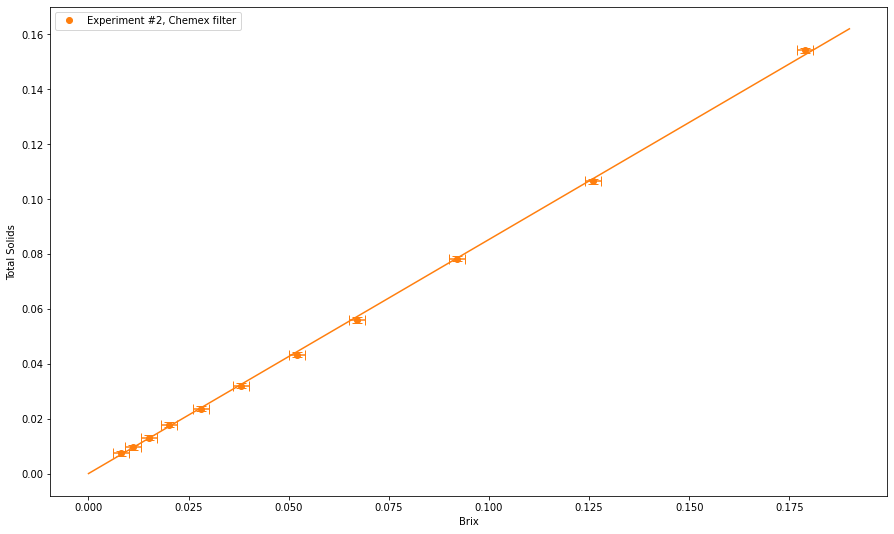

In [12]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brix')
ax.set_ylabel('Total Solids')

# Plot labels
labels = ['Experiment #2, Chemex filter']

for i, trial_id in enumerate([4]):
    one_trial = measurements[measurements['trial_id'] == trial_id]
    weight_id = one_trial['weight_id'].max()
    df = one_trial[one_trial['weight_id'] == weight_id]

    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])

    # Get trial description
    label = labels[i]

    # Plot the data
    p = ax.plot(xs, ys, label=label, marker='o', linestyle='None', color=f'C1')
    ax.errorbar(xs, ys, xerr=s_brix, yerr=df['s_tds'], linestyle='None', capsize=5, color=p[0].get_color())

    # Plot best fit
    xs = np.linspace(0., 0.19, 2)
    m = slopes['slope'][(slopes['weight_id'] == weight_id) & (slopes['trial_id'] == trial_id)].values[0]
    ys = m * xs
    ax.plot(xs, ys, color=p[0].get_color())

# Add a legend to the plot
ax.legend()

We can also plot the residuals:

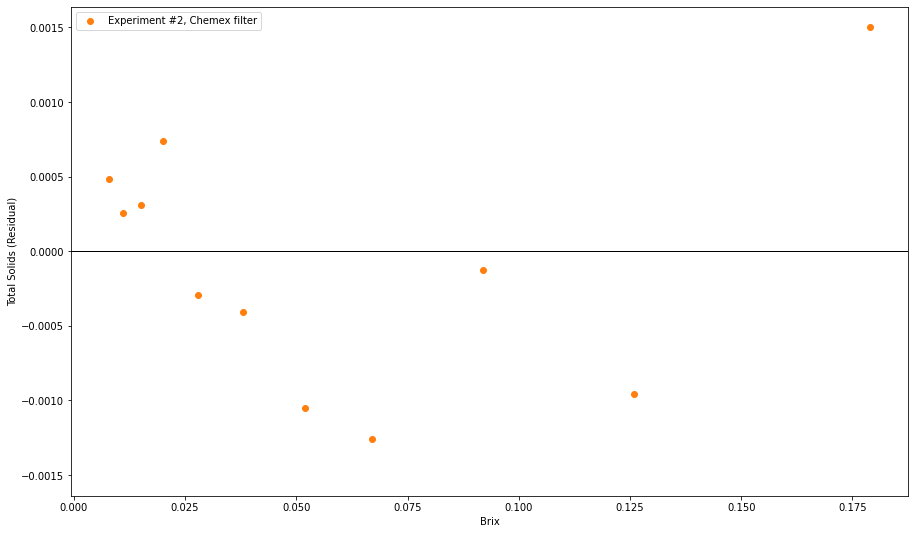

In [13]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Brix')
ax.set_ylabel('Total Solids (Residual)')

# Plot labels
labels = ['Experiment #2, Chemex filter']

for i, trial_id in enumerate([4]):
    one_trial = measurements[measurements['trial_id'] == trial_id]
    weight_id = one_trial['weight_id'].max()
    df = one_trial[one_trial['weight_id'] == weight_id]

    # Get plot data
    xs = np.array(df['brix_percent'] / 100.)
    ys = np.array(df['tds'])

    # Get best fit
    m = slopes['slope'][(slopes['weight_id'] == weight_id) & (slopes['trial_id'] == trial_id)].values[0]
    ys_fit = m * xs

    # Plot residuals
    ax.scatter(xs, ys - ys_fit, color='C1', label=labels[i])

# Make plot symmetrical
yrange = np.max(np.abs(ax.get_ylim()))
ax.set_ylim((-yrange, yrange))

# Draw horizontal line at y = 0
plt.axhline(y=0., color='k', lw=1)

# Add a legend to the plot
ax.legend()

# Maximum likelihood

Next, we're going to fit the model to our data by maximizing the likelihood of the data given a particular set of model parameters. First, we assign a zero-based index to each of our trials.

In [14]:
# Assign config id to each trial/measurement
trials['config_id'] = range(len(trials))
measurements = pd.merge(measurements, trials['config_id'], how='left', left_on='trial_id', right_index=True)
measurements.tail()

,trial_id,sample_id,weight_empty_boat,brix_percent,weight_boat_plus_liquid,notes,weight_id,dry_weight,weight_dissolved,weight_solid,tds,s_tds,config_id
289,4,7,0.438,2.8,3.493,NaN,6,0.510,3.055,0.072,0.023568,0.000915,3
290,4,8,0.435,2.0,3.584,NaN,6,0.491,3.149,0.056,0.017783,0.000890,3
291,4,9,0.433,1.5,3.488,NaN,6,0.473,3.055,0.040,0.013093,0.000920,3
292,4,10,0.435,1.1,3.551,NaN,6,0.465,3.116,0.030,0.009628,0.000903,3
293,4,11,0.436,0.8,3.448,NaN,6,0.458,3.012,0.022,0.007304,0.000936,3


Then we convert our tables into arrays.

In [15]:
# Get experiment data
expt_brix = measurements['brix_percent'].values / 100.
expt_tds = measurements['tds'].values
sigma_tds = measurements['s_tds'].values
config_id = measurements.groupby(['trial_id', 'weight_id']).ngroup().values
N = int(config_id.max() + 1)
config_id

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17], dtype=int64)

Now we'll define the probability distribution for a single measurement.

In [16]:
def get_pdf(X, Y, brix, tds, s_brix, s_tds):
    return norm.pdf(X, brix, s_brix) * norm.pdf(Y, tds, s_tds)

Next, we integrate the individual distributions along the model curve to get the individual likelihood for that curve.

In [17]:
def single_likelihood(theta, brix, tds, s_brix, s_tds, config_id_i):
    m = theta[config_id_i]
    xs = np.linspace(brix - s_brix * 10., brix + s_brix * 10., 201)
    ys = m * xs
    zs = get_pdf(xs, ys, brix, tds, s_brix, s_tds)
    zs = (zs[:-1] + zs[1:]) / 2.
    return sum(zs) * (xs[1] - xs[0])

To get the likelihood for a set of measurements, we multiply the likelihoods for the individual measurements. Equivalently, we can get the log-likelihood for the set of measurements by adding up the log-likelihoods of the individual measurements.

In [18]:
def log_likelihood(theta, brix, tds, s_brix, s_tds, config_id):
    likelihoods = [single_likelihood(theta, brix_i, tds_i, s_brix, s_tds_i, config_id_i) 
                   for brix_i, tds_i, s_tds_i, config_id_i in zip(brix, tds, sigma_tds, config_id)]
    if np.all(np.array(likelihoods) > 0):
        return sum(np.log(likelihoods))
    else:
        return -np.inf

Now we can maximize likelihood to find the best fit curve for each configuration.

In [19]:
nll = lambda *args: -log_likelihood(*args)

# Initial values
initial = np.array([0.85] * N)

# Maximize likelihood
soln = minimize(nll, initial, args=(expt_brix, expt_tds, s_brix, sigma_tds, config_id), 
                method='Nelder-Mead')

fit_theta = soln.x
fit_theta

array([0.91000168, 0.88550998, 0.87724535, 0.8861143 , 0.86103073,
       0.85832997, 0.95329822, 0.92046412, 0.91274799, 0.89998309,
       0.89806299, 0.89503478, 0.88268681, 0.86589815, 0.85740755,
       0.85710047, 0.85255574, 0.85184139])

Let's plot this.

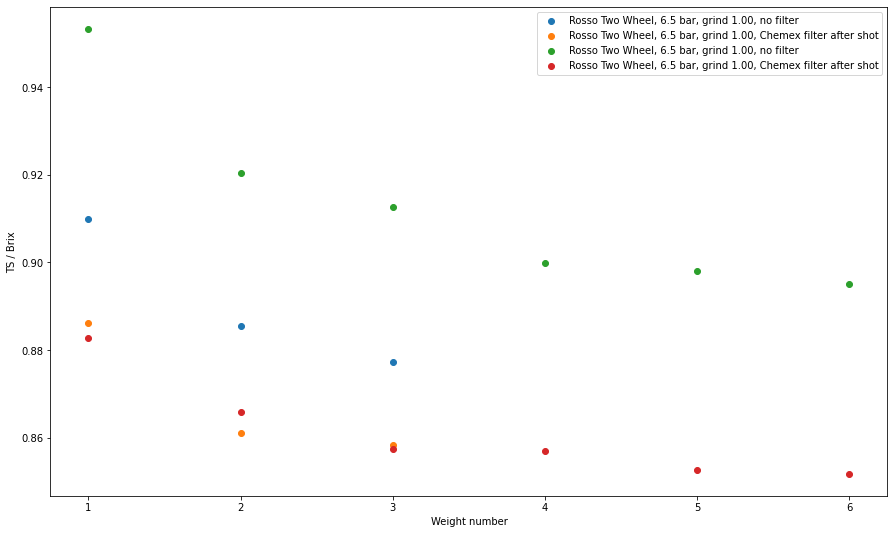

In [20]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Weight number')
ax.set_ylabel('TS / Brix')

for i in range(N):
    trial_id = measurements[config_id == i]['trial_id'].values[0]
    weight_id = measurements[config_id == i]['weight_id'].values[0]
    
    color = trials['config_id'][trial_id]
    
    if weight_id == 1: label = trials['description'][trial_id]
    else:              label = None

    ax.scatter([weight_id], [fit_theta[i]], marker='o', color=f'C{color}', label=label)
    
# Add a legend to the plot
ax.legend()

# Markov chain Monte Carlo

Now we set up Markov chain Monte Carlo. First we define the prior and posterior.

In [21]:
def log_prior(theta):
    m_i = theta
    if np.all(m_i >= 0):
        return -np.sum(np.log(m_i))
    else:
        return -np.inf

def log_posterior(theta, brix, tds, s_brix, s_tds, config_id):
    lp = log_prior(theta)
    ll = log_likelihood(theta, brix, tds, s_brix, s_tds, config_id)
    if np.isfinite(lp) and np.isfinite(ll) :
        return lp + ll
    else:
        return -np.inf

Now we set up the optimization parameters.

In [22]:
ndim = 1  # number of parameters in the model
nwalkers = 2 * ndim  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nthin = 100 # thin by about half the autocorrelation time
nsteps = 10000  # number of MCMC steps to take

And finally we sample the distribution using emcee.

In [23]:
# Get filename for cached data
filename = 'emcee/saved.csv'

if os.path.exists(filename):
    # Load samples from cache
    flat_samples = np.loadtxt(filename, delimiter=',')
else:
    np.random.seed(42)

    # Initialize saved samples
    flat_samples = np.empty((int((nsteps - nburn) / nthin) * nwalkers, 0))

    for i in range(N):
        # Get data for this configuration
        expt_brix_i = expt_brix[config_id == i]
        expt_tds_i = expt_tds[config_id == i]
        sigma_tds_i = sigma_tds[config_id == i]

        # Iniitalize the walkers
        starting_guesses = fit_theta[i:i+1] + [1e-4] * np.random.randn(nwalkers, ndim)

        # Run sampler
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                        args=[expt_brix_i, expt_tds_i, s_brix, sigma_tds_i, [0] * len(expt_brix_i)])
        sampler.run_mcmc(starting_guesses, nsteps, progress=True)

        # Display autocorrelation time
        sampler.get_autocorr_time(quiet=True)

        # Append samples
        fs = sampler.get_chain(discard=nburn, thin=nthin, flat=True)
        flat_samples = np.append(flat_samples, fs, axis=1)
    
    # Save samples
    np.savetxt(filename, flat_samples, delimiter=',')

First, let's get the fit parameters for each configuration.

In [24]:
labels = ['m']
txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"

for i in range(N):
    trial_id = measurements[config_id == i]['trial_id'].values[0]
    weight_id = measurements[config_id == i]['weight_id'].values[0]

    print(f'{i}: ' + trials['description'][trial_id] + f', weight #{weight_id}')

    fs = flat_samples[:, [i]]

    mcmc = np.percentile(fs[:, 0], [16, 50, 84])
    q = np.diff(mcmc)
    display(Math(txt.format(mcmc[1], q[0], q[1], labels[0])))

0: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #1


<IPython.core.display.Math object>

1: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #2


<IPython.core.display.Math object>

2: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #3


<IPython.core.display.Math object>

3: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #1


<IPython.core.display.Math object>

4: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #2


<IPython.core.display.Math object>

5: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #3


<IPython.core.display.Math object>

6: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #1


<IPython.core.display.Math object>

7: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #2


<IPython.core.display.Math object>

8: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #3


<IPython.core.display.Math object>

9: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #4


<IPython.core.display.Math object>

10: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #5


<IPython.core.display.Math object>

11: Rosso Two Wheel, 6.5 bar, grind 1.00, no filter, weight #6


<IPython.core.display.Math object>

12: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #1


<IPython.core.display.Math object>

13: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #2


<IPython.core.display.Math object>

14: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #3


<IPython.core.display.Math object>

15: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #4


<IPython.core.display.Math object>

16: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #5


<IPython.core.display.Math object>

17: Rosso Two Wheel, 6.5 bar, grind 1.00, Chemex filter after shot, weight #6


<IPython.core.display.Math object>

We can plot the slope of the dry sample in experiment \#2:

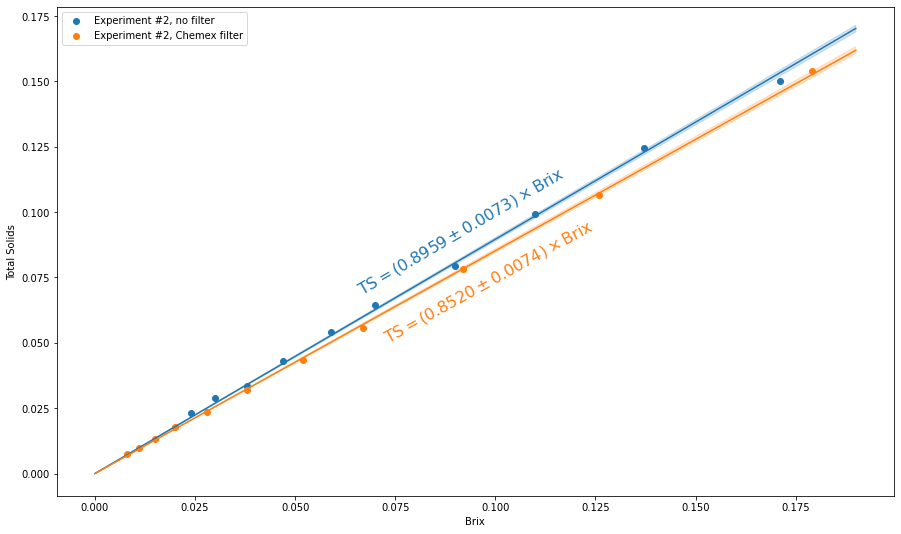

In [25]:
def plot_fit(ax, brix, m, color=None, label=None):
    tds = m * brix
    
    # Draw maximum likelihood curve
    traj, = ax.plot(brix, tds, color=color, label=label)

def plot_points(ax, brix, tds, color=None, label=None):
    # Draw data points
    ax.scatter(brix, tds, color=color, label=label)
    
def plot_labels(ax):
    ax.set_xlabel('Brix')
    ax.set_ylabel('Total Solids')

def plot_credible_interval(ax, brix, samples, color=None):
    m = samples

    tds = m * brix
    tds_lower, tds_upper = np.percentile(tds, [16, 84], axis=0)

    # Plot 95% credible interval
    plt.fill(np.append(brix, brix[::-1]), 
             np.append(tds_upper, tds_lower[::-1]), 
             color=color, alpha=0.2)

def plot_annotation(ax, brix, samples, color, trial_id):
    # Get slope
    mcmc = np.percentile(samples[:, 0], [16, 50, 84])
    q = np.diff(mcmc)
    
    # Get best fit line
    tds = mcmc[1] * brix
    
    # Get slope in plot
    p1 = ax.transData.transform_point((brix[0], tds[0]))
    p2 = ax.transData.transform_point((brix[-1], tds[-1]))
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    rotn = np.degrees(np.arctan2(dy, dx))
    
    # Get label position
    xylabel = ((brix[0]+brix[-1])/2, (tds[0]+tds[-1])/2)
    if trial_id == 3: xytext = (-14, 20)
    else: xytext = (14, -20)

    # Get label
    label = r'$\mathrm{TS} = ' + r'({slope:.4f} \pm {dev:.4f})'.format(slope=mcmc[1], dev=max(q[0], q[1])) + r'\times \mathrm{Brix}$'
    
    # Draw annotation
    ax.annotate(label, xy=xylabel, xytext=xytext, textcoords='offset points', ha='center', va='center', rotation=rotn, color=color, fontsize=16)

# Plot labels
labels = ['Experiment #2, no filter', 'Experiment #2, Chemex filter']

#fig, ax = plt.subplots(figsize=(9,9), dpi=300)
#fig.patch.set_facecolor('white')

fig, ax = plt.subplots(figsize=(15,9))

plot_labels(ax)

ci = 0
for i in range(N):
    trial_id = measurements[config_id == i]['trial_id'].values[0]
    weight_id = measurements[config_id == i]['weight_id'].values[0]
    
    if not trial_id in [3, 4]:
        continue    
    if weight_id != measurements['weight_id'][measurements['trial_id'] == trial_id].max():
        continue

    one_trial = measurements[measurements['trial_id'] == trial_id]
    df = one_trial[one_trial['weight_id'] == weight_id]

    # Get flat samples this shot
    fs = flat_samples[:, [i]]
    
    # Get best fit parameters
    fit_m = np.percentile(fs[:, 0], 50)

    # Get plot colour and label
    color = f'C{ci}'
    label = labels[ci]

    # Plot maximum likelihood fit
    plot_fit(ax, 
             np.linspace(0., 0.19, 201), 
             fit_m, 
             color)

    # Plot points
    plot_points(ax, df['brix_percent'] / 100., df['tds'], color, label)

    # Plot 95% credible interval
    plot_credible_interval(ax, 
                           np.linspace(0., 0.19, 201), 
                           fs, color)
    
    plot_annotation(ax, 
                    np.linspace(0., 0.19, 201), 
                    fs, color, trial_id)
    
    ci += 1

plt.xlim(xlim)
plt.ylim(ylim)

ax.legend()

Finally, we plot drying progress for all experiments.

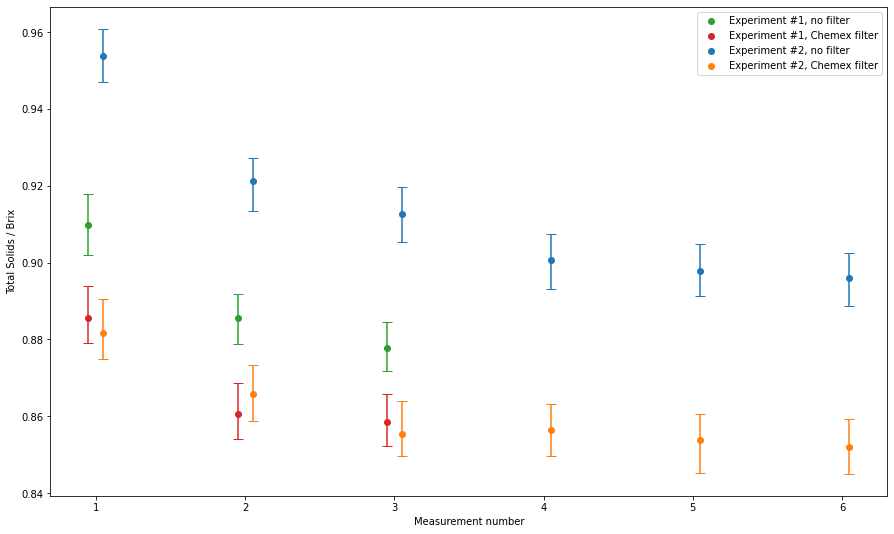

In [26]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))
#fig.patch.set_facecolor('white')

# Label the axes
ax.set_xlabel('Measurement number')
ax.set_ylabel('Total Solids / Brix')

labels = {1: 'Experiment #1, no filter', 
          2: 'Experiment #1, Chemex filter', 
          3: 'Experiment #2, no filter', 
          4: 'Experiment #2, Chemex filter'}

for i in range(N):
    trial_id = measurements[config_id == i]['trial_id'].values[0]
    weight_id = measurements[config_id == i]['weight_id'].values[0]
    color = trials['config_id'][trial_id + 2 if trial_id < 3 else trial_id - 2]
    offset = -0.05 if i < 6 else 0.05
    
    if weight_id == 1:
        label = labels[trial_id]
    else:
        label = None

    fs = flat_samples[:, [i]]

    mcmc = np.percentile(fs[:, 0], [16, 50, 84])
    q = np.diff(mcmc)
    
    ax.errorbar([weight_id + offset], [mcmc[1]], yerr=[[q[0]], [q[1]]], capsize=5, color=f'C{color}')
    ax.scatter([weight_id + offset], [mcmc[1]], marker='o', color=f'C{color}', label=label)
    
# Add a legend to the plot
ax.legend()